# Third Classifier

This time, classify the data *only* using price data.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(context='talk')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 343)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(price_cols | duration_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 48)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.607111111111111


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.153846,0.807018,0.882353,0.166667,0.532680
1,0.125000,0.754386,0.823529,0.166667,0.539216
2,0.181818,0.684211,0.725490,0.333333,0.516340
3,0.066667,0.508772,0.549020,0.166667,0.338235
4,0.068966,0.526316,0.568627,0.166667,0.401961
5,0.190476,0.701754,0.745098,0.333333,0.591503
6,0.000000,0.771930,0.862745,0.000000,0.665033
7,0.285714,0.824561,0.882353,0.333333,0.776144
8,0.000000,0.839286,0.940000,0.000000,0.870000
9,0.000000,0.836364,0.920000,0.000000,0.840000


missing_price_per_min:nmlzd_count       0.232793
missing_price:nmlzd_count               0.231598
missing_duration_in_mins:nmlzd_count    0.230807
duration_in_mins:std                    0.020843
price:std                               0.018331
price:max                               0.017942
price:min                               0.016846
missing_price:std                       0.015803
missing_price:mean                      0.013829
missing_price_per_min:std               0.013544
price:mean                              0.013493
missing_duration_in_mins:std            0.012901
missing_price:min                       0.012525
duration_in_mins:min                    0.009843
duration_in_mins:max                    0.009793
missing_price:50%                       0.009734
price_per_min:std                       0.009397
missing_price:25%                       0.009086
duration_in_mins:mean                   0.008891
price_per_min:mean                      0.008384
dtype: float64


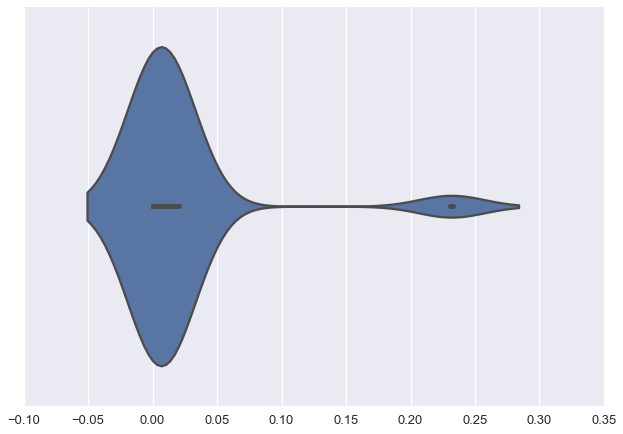

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

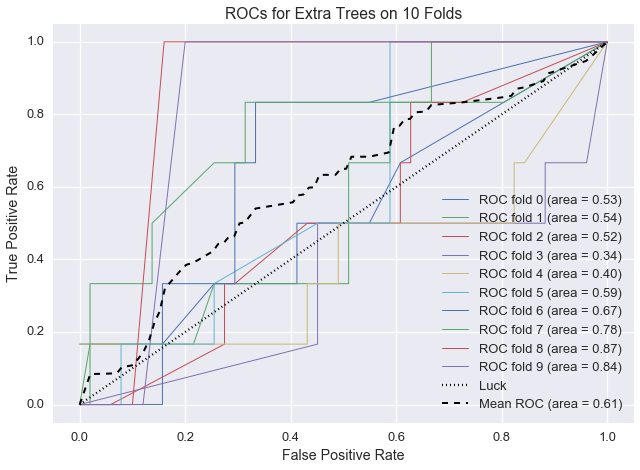

In [9]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [10]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [11]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.5956732026143791


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.000000,0.771930,0.862745,0.000000,0.519608
1,0.142857,0.789474,0.862745,0.166667,0.539216
2,0.181818,0.684211,0.725490,0.333333,0.586601
3,0.066667,0.508772,0.549020,0.166667,0.406863
4,0.133333,0.543860,0.568627,0.333333,0.343137
5,0.100000,0.684211,0.745098,0.166667,0.562092
6,0.000000,0.754386,0.843137,0.000000,0.627451
7,0.285714,0.824561,0.882353,0.333333,0.661765
8,0.000000,0.839286,0.940000,0.000000,0.870000
9,0.000000,0.836364,0.920000,0.000000,0.840000


missing_price:nmlzd_count               0.241859
missing_price_per_min:nmlzd_count       0.235362
missing_duration_in_mins:nmlzd_count    0.228356
price:std                               0.026439
price:max                               0.023274
missing_price:std                       0.021716
price:min                               0.018728
missing_price:mean                      0.018226
price:mean                              0.017195
missing_duration_in_mins:std            0.016603
price:nmlzd_count                       0.016169
duration_in_mins:std                    0.015264
missing_price_per_min:std               0.013660
price_per_min:mean                      0.010978
price_per_min:min                       0.009307
missing_price_per_min:mean              0.009054
missing_duration_in_mins:mean           0.008400
price_per_min:max                       0.007052
price_per_min:std                       0.006860
duration_in_mins:nmlzd_count            0.006550
dtype: float64


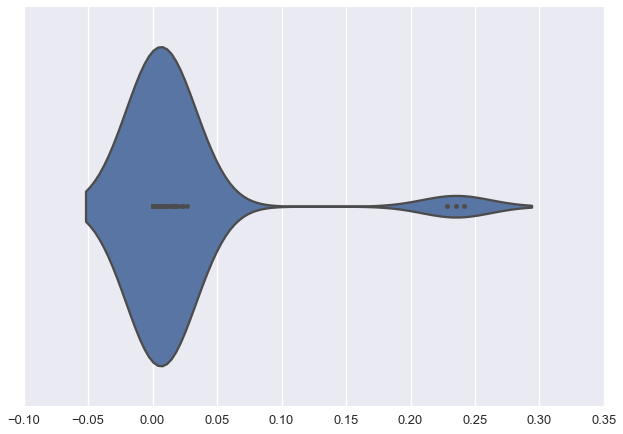

In [12]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

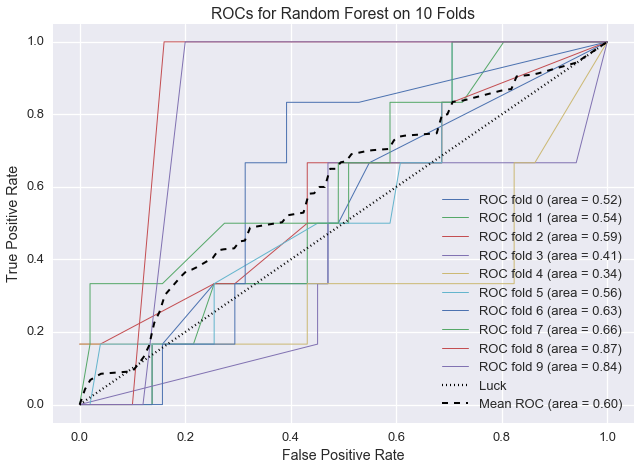

In [13]:
draw_rocs(this_metrics, 'Random Forest')